# Crime in Denmark - Distributed by Country of Origin

In this study, we aim to examine the criminal involvement of different nationalities in Denmark over the period from 2017 to 2022. Our primary objective is to identify the origin countries of individuals who have been recorded in criminal activities and to analyze the representation of these nationalities in relation to their proportion of the total Danish population. This analysis seeks to determine whether certain nationalities are overrepresented or underrepresented in criminal statistics compared to their demographic share. This investigation provides insights into patterns of crime among various national groups, contributing to a better understanding of social integration.

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import clear_output

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1) Reading and cleaning data

We start by importing the dataset from "Danmarks Statistik". We import a dataset that examines which country of origin the people who commits crime in Denmark come from. The Dataset is called "STRAFNA3"

In [3]:
import datetime

import pandas_datareader 
from dstapi import DstApi 

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})


In [4]:
ind = DstApi('STRAFNA3')

We show a summary of the data in a table to give an overview over the different variables and values in the dataset we use.

In [5]:
tabsum = ind.tablesummary(language='en')
display(tabsum)

Table STRAFNA3: Persons guilty in crimes by sex, age, country of origin and time
Last update: 2023-12-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,KOEN,2,M,Men,K,Women,False
1,ALDER,4,TOT,"Age, total",50-79,50-79 years,False
2,IELAND,75,0000,Total,7300,"Other countries, non-western",False
3,Tid,21,2000,2000,2022,2022,True


We then do some cleaning of the data by only having the value "TOT" for variable "ALDER" and the years we examine in this project is from 2017 until 2022. The reason for this limitation is because we only want to show how the crime in Denmark has developed in recent years.

In [6]:
# The _define_base_params -method gives us a nice template
params = ind._define_base_params(language='en')
variables = params['variables'] 
variables[1]['values'] = ['TOT']
variables[3]['values'] = ['2017', '2018', '2019', '2020', '2021', '2022']
params

{'table': 'strafna3',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'KOEN', 'values': ['*']},
  {'code': 'ALDER', 'values': ['TOT']},
  {'code': 'IELAND', 'values': ['*']},
  {'code': 'Tid', 'values': ['2017', '2018', '2019', '2020', '2021', '2022']}]}

In [7]:
inc_api = ind.get_data(params=params)

We a print out a list that shows the different countries in the dataset. We see that the dataset includes:'Denmark', 'Other countries, non-western', 'Other countries, total', 'Total'. We remove these values from our data since we want to examine which specific countries of origin commits the most crime in Denmark. 

In [8]:
# Choose only contires
represented_countries = inc_api['IELAND'].unique()

# Printing the contries from the dataset
print("Represented Countries:")
for country in represented_countries:
    print(country)


Represented Countries:
Yugoslavia
Poland
Portugal
Romania
Switzerland
Soviet Union
Spain
United Kingdom
Turkey
Hungary
Germany
Austria
Algeria
Ethiopia
Ghana
Kenya
Morocco
Nigeria
South Africa
Tanzania
Tunisia
Uganda
Egypt
Somalia
Argentina
Brazil
Canada
Chile
USA
Afghanistan
Myanmar
Sri Lanka
India
Indonesia
Iraq
Iran
Israel
Japan
Jordan
China
Kuwait
Lebanon
Vietnam
Pakistan
Philippines
Syria
Thailand
Australia
Estonia
Latvia
Lithuania
Russia
Ukraine
Croatia
Bosnia and Herzegovina
Republic of North Macedonia
Yugoslavia, Federal Republic
Other countries, total
Other countries, western
Other countries, non-western
Total
Denmark
Finland
Iceland
Norway
Sweden
Belgium
Bulgaria
Czechoslovakia
France
Greece
Netherlands
Ireland
Italy
Serbia and Montenegro


# 2) Crime shares for different countries of origin

We show the different crime shares for the 5 countries that commits the most crime. We visualize it by creating a bar chart. We examine the years 2017-2022 by using a slider. We also seperate men from women by using a drop down menu

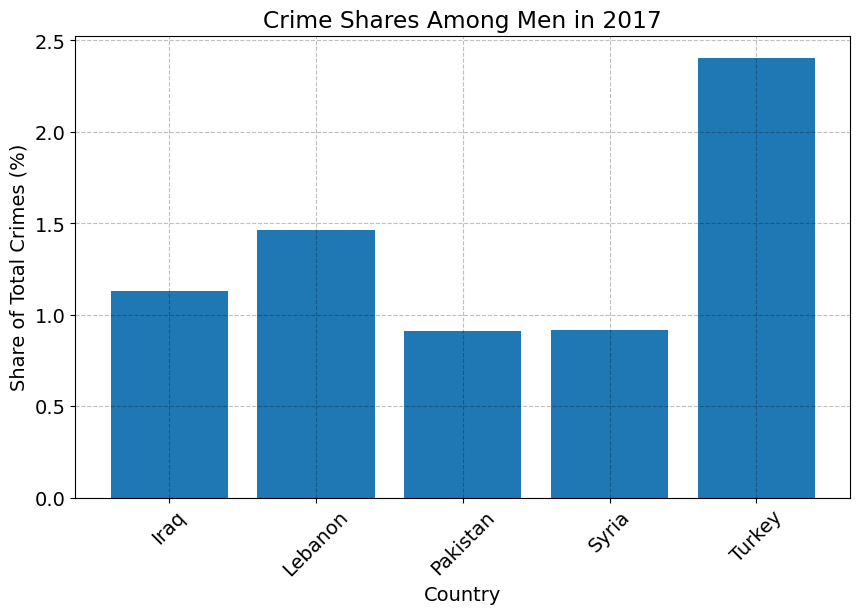

In [9]:
def plot_crime_shares(gender, year):
    # Filter data based on gender and the selected year
    total_crimes_year = inc_api[(inc_api['TID'] == year) & (inc_api['IELAND'] == 'Total')]['INDHOLD'].sum()
    
    # Exclude specified countries
    exclude_countries = ['Denmark', 'Other countries, non-western', 'Other countries, total', 'Total']
    
    # Find top 5 countries and excluding specified countries
    top_countries_gender = inc_api[(inc_api['KOEN'] == gender) & (inc_api['TID'] == year) & (~inc_api['IELAND'].isin(exclude_countries))].nlargest(5, 'INDHOLD')['IELAND'].tolist()
    
    filtered_data = inc_api[(inc_api['KOEN'] == gender) & (inc_api['TID'] == year) & (inc_api['IELAND'].isin(top_countries_gender))].copy()
    
    if total_crimes_year > 0:  # We make sure that the data can not be 0
        filtered_data['Share'] = filtered_data['INDHOLD'] / total_crimes_year * 100
        
        # sorting datanames for the graph so it is alphabetic to the left
        filtered_data = filtered_data.sort_values(by='IELAND')
        
        plt.figure(figsize=(10, 6))
        plt.bar(filtered_data['IELAND'], filtered_data['Share'])
        plt.title(f'Crime Shares Among {gender} in {year}')
        plt.xlabel('Country')
        plt.ylabel('Share of Total Crimes (%)')
        plt.xticks(rotation=45)
        plt.show()

def on_controls_change(change):
    clear_output(wait=True)
    # This code is to ensure that the controls displays after clearing
    display(widgets.HBox([gender_dropdown, year_slider]))
    plot_crime_shares(gender_dropdown.value, year_slider.value)

# Gender dropdown widget
gender_dropdown = widgets.Dropdown(options=['Men', 'Women'], description='Gender:', value='Men')

# Year slider widget
year_slider = widgets.IntSlider(min=2017, max=2022, step=1, description='Year:', value=2017)

# Combine the gender dropdown and year slider into a box
controls = widgets.HBox([gender_dropdown, year_slider])

# Observe changes for both widgets using the same handler
gender_dropdown.observe(on_controls_change, names='value')
year_slider.observe(on_controls_change, names='value')

# Display of widgets and plot
display(controls)
plot_crime_shares(gender_dropdown.value, year_slider.value)


We can conclude by the bar chart that people with origin from Turkey and Lebanon commits the highest share of crime in Denmark for both men and women.

# 3) Distribution of crimes between the top 5 countries of origin

We create a circle diagram to show the distribution of crimes between the 5 countries that commits the most crime. We again seperate men from women with a drop down.

Dropdown(description='Gender:', options=('Men', 'Women'), value='Men')

IntSlider(value=2017, description='Year', max=2022, min=2017)

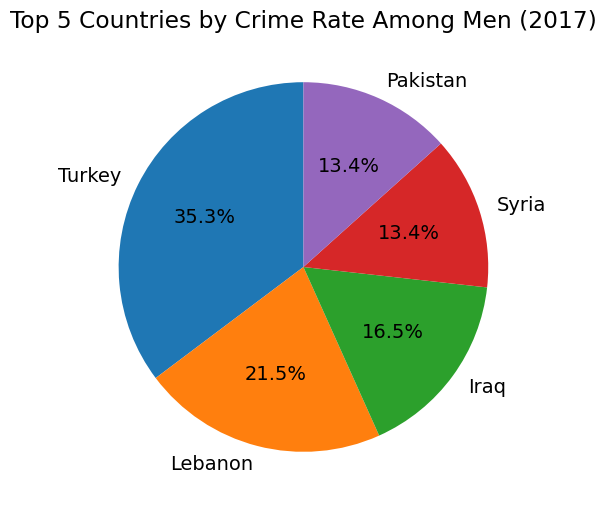

In [10]:
def plot_pie_chart(gender, selected_year):
    # Using the correct data (excluding some contires)
    filtered_data = inc_api[(inc_api['KOEN'] == gender) & 
                            (inc_api['IELAND'] != 'Total') & 
                            (inc_api['IELAND'] != 'Denmark') & 
                            (inc_api['IELAND'] != 'Other countries, non-western') & 
                            (inc_api['IELAND'] != 'Other countries, total') & 
                            (inc_api['TID'].astype(int) == selected_year)]
    top_countries = filtered_data.groupby('IELAND')['INDHOLD'].sum().nlargest(5)
    
    plt.figure(figsize=(10, 6))
    top_countries.plot(kind='pie', autopct='%1.1f%%', startangle=90, ylabel='', 
                       title=f'Top 5 Countries by Crime Rate Among {gender} ({selected_year})')
    plt.show()

def on_gender_year_selected(change):
    clear_output(wait=True)
    display(gender_dropdown)
    display(year_slider)
    plot_pie_chart(gender_dropdown.value, year_slider.value)

gender_dropdown = widgets.Dropdown(options=['Men', 'Women'], description='Gender:')
year_slider = widgets.IntSlider(description='Year', min=2017, max=2022, value=2017)

gender_dropdown.observe(on_gender_year_selected, names='value')
year_slider.observe(on_gender_year_selected, names='value')

display(gender_dropdown)
display(year_slider)

plot_pie_chart('Men', 2017)  # Default display


It is seen by the circle diagram that Turkey commits approxiamtely 1/3 of the total crime committed by the five countries. The distribution are quite similar for both men and women.

# 4) The crime development 

We now show how the number of crimes have developed for the different origins during the investigated period. We again seperate men and women by using af drop down. The 5 countries we examine are the ones that have historically comitted the most crime for each gender during 2017 - 2022.

Dropdown(description='Gender:', options=('Men', 'Women'), value='Men')

<Figure size 1000x600 with 0 Axes>

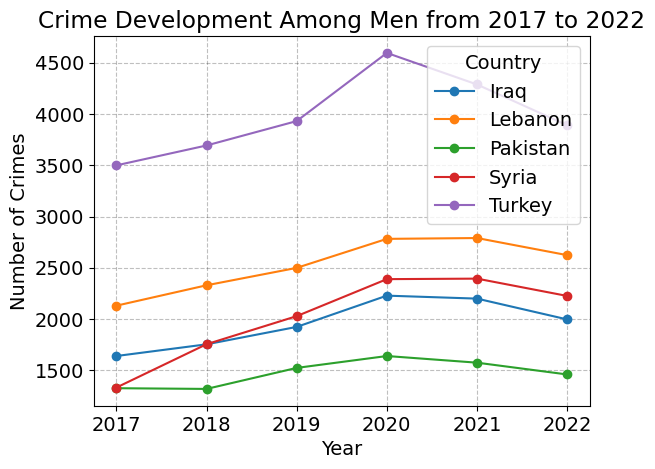

In [12]:
def plot_crime_development(gender):
    # Filter by gender and year
    filtered_data = inc_api[(inc_api['KOEN'] == gender) & (inc_api['TID'].between(2017, 2022))]
    
    # Define countries based on gender
    countries = []
    if gender == 'Men':
        countries = ["Turkey", "Pakistan", "Iraq", "Syria", "Lebanon"]
    elif gender == 'Women':
        countries = ["Turkey", "Pakistan", "Iraq", "Poland", "Lebanon"]
    
    # Include only the specified countries
    filtered_data = filtered_data[filtered_data['IELAND'].isin(countries)]
    
    # We now group by country and year and then sum
    grouped_data = filtered_data.groupby(['IELAND', 'TID'])['INDHOLD'].sum().unstack()
    
    # Here we plot the data
    plt.figure(figsize=(10, 6))
    grouped_data.T.plot(kind='line', marker='o')
    plt.title(f'Crime Development Among {gender} from 2017 to 2022')
    plt.xlabel('Year')
    plt.ylabel('Number of Crimes')
    plt.grid(True)
    plt.legend(title='Country')
    plt.show()

def on_gender_selected(change):
    clear_output(wait=True)
    display(gender_dropdown)
    plot_crime_development(change['new'])

gender_dropdown = widgets.Dropdown(options=['Men', 'Women'], description='Gender:')
gender_dropdown.observe(on_gender_selected, names='value')

display(gender_dropdown)
plot_crime_development('Men')


The diagram shows that the number of crimes had it's peak in 2020. Especially the crime comitted by people who originates from Turkey had a big rise in 2020. From 2020 and forward the number of crime has generally been at a stable level, with the exception of Turkey. For Turkey, the number of crimes have fallen for both men and women since 2020.

# 5) Importing and cleaning new dataset

We import the dataset "FOLK2" from Danmarks Statistik. This data contains a description of the population composition in Denmark. We import this dataset to examine if the origin countries we have investigated in this study are over- or underrepresented in criminal statistics compared to their demographic share in Denmark.

We start by creating a table which gives an overview of the different variables and values of the new dataset.

In [13]:
oprindelse = DstApi('FOLK2')

tabsum = oprindelse.tablesummary(language='en')
display(tabsum)

Table FOLK2: Population 1. January by age, sex, ancestry, citizenship, country of origin and time
Last update: 2024-02-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,ALDER,126,0,0 years,125,125 years,False
1,KØN,2,M,Men,K,Women,False
2,HERKOMST,3,5,Persons of Danish origin,3,Descendant,False
3,STATSB,2,DANSK,Denmark,UDLAND,Foreign,False
4,IELAND,241,5100,Denmark,5999,Not stated,False
5,Tid,45,1980,1980,2024,2024,True


We then again do some cleaning of the data by only having the values for the years 2017-2022. The reason for this limitation is because we want to examine the same period as the first part of the study.

In [15]:
params = oprindelse._define_base_params(language='en')
variables = params['variables'] 
variables[5]['values'] = ['2017', '2018', '2019', '2020', '2021', '2022']
params

{'table': 'folk2',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'ALDER', 'values': ['*']},
  {'code': 'KØN', 'values': ['*']},
  {'code': 'HERKOMST', 'values': ['*']},
  {'code': 'STATSB', 'values': ['*']},
  {'code': 'IELAND', 'values': ['*']},
  {'code': 'Tid', 'values': ['2017', '2018', '2019', '2020', '2021', '2022']}]}

In [16]:
oprindelse_api = oprindelse.get_data(params=params)

# 6) Population Composition 

We create a bar chart to display the proportions of men and women from various countries of origin within the total Danish population. This enable us to examine any significant differences in how men and women from different countries are represented within the Danish population for the selected countries. Additionally, we create this bar chart to see if this chart has similarities with the chart in question 2. This helps us investigate if the selected countries are over- or underrepresented.

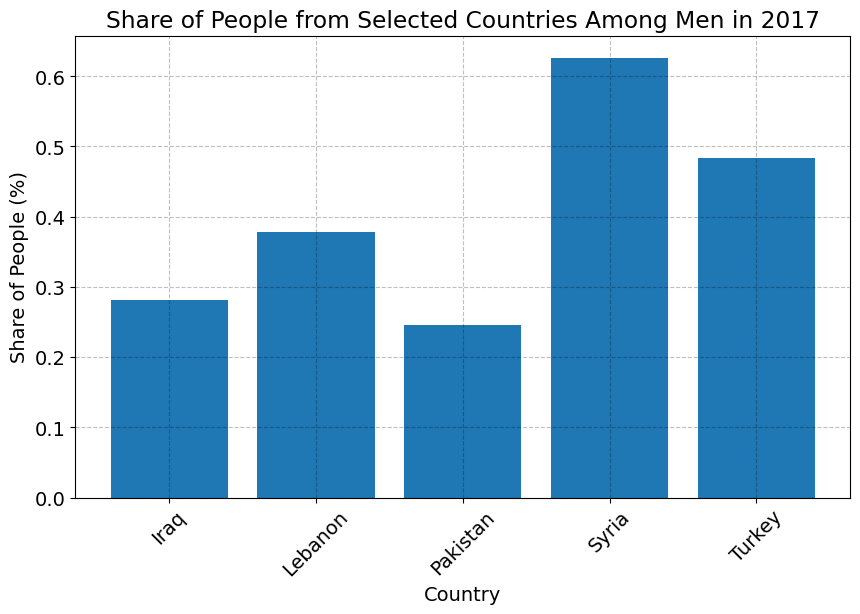

In [17]:
def plot_people_shares(year, gender):
    # Again we filter for time and gender
    filtered_data = oprindelse_api[(oprindelse_api['TID'] == year) & 
                                   (oprindelse_api['KØN'] == gender)]
    
    # Define countries based on gender (the contires is selsected based on previuous figures)
    countries_of_interest = []
    if gender == 'Men':
        countries_of_interest = ['Turkey', 'Pakistan', 'Iraq', 'Syria', 'Lebanon']
    elif gender == 'Women':
        countries_of_interest = ['Turkey', 'Pakistan', 'Iraq', 'Poland', 'Lebanon']
    
    # Focus on the specified countries
    filtered_data = filtered_data[filtered_data['IELAND'].isin(countries_of_interest)]
    
    total_people = filtered_data['INDHOLD'].sum()
    filtered_data['Share'] = (filtered_data['INDHOLD'] / total_people) * 100
    
    # Sort the filtered data by country name so it is alphabetic
    filtered_data = filtered_data.sort_values(by='IELAND')
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(filtered_data['IELAND'], filtered_data['Share'])
    plt.title(f'Share of People from Selected Countries Among {gender} in {year}')
    plt.xlabel('Country')
    plt.ylabel('Share of People (%)')
    plt.xticks(rotation=45)
    plt.show()

def on_controls_change(change):
    clear_output(wait=True)
    display(widgets.HBox([year_slider, gender_dropdown]))
    plot_people_shares(year_slider.value, gender_dropdown.value)

# Widgets is created
year_slider = widgets.IntSlider(min=2017, max=2022, step=1, description='Year:', value=2017)
gender_dropdown = widgets.Dropdown(options=['Men', 'Women'], description='Gender:', value='Men')

year_slider.observe(on_controls_change, names='value')
gender_dropdown.observe(on_controls_change, names='value')

# Displaying data
display(widgets.HBox([year_slider, gender_dropdown]))
plot_people_shares(year_slider.value, gender_dropdown.value)


For men the highest population share has origins from Syria of the 5 selected countries. For the period 2017-2022 approximately 0.6% of the Danish population are men with origins from Syria. The next most popular country is Turkey.
For women the highest population share has origins from Poland of the 5 selected countries. For the same period approximately 0.6% of the Danish population are women with origins from Poland. The next most popular of the 5 countries is Turkey for women too.

# 7) Over- or underrepresented

We now compare the crime share with population share. We do this to investigate if the relative high crime shares for each origin country is caused by a high population share.

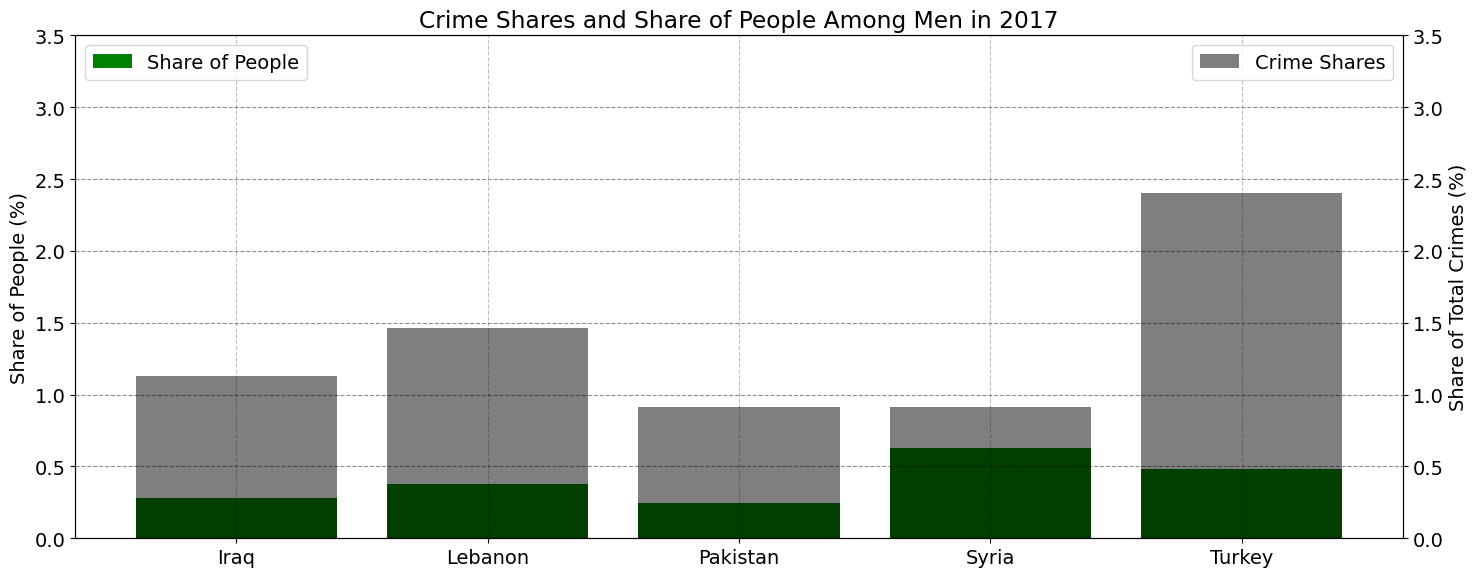

In [19]:
def plot_comparison(year, gender):
    fig, ax1 = plt.subplots(figsize=(15, 6))
    
    # Again defining contires based on gender
    if gender == 'Men':
        countries_of_interest = ['Turkey', 'Pakistan', 'Iraq', 'Syria', 'Lebanon']
    elif gender == 'Women':
        countries_of_interest = ['Turkey', 'Pakistan', 'Iraq', 'Poland', 'Lebanon']
    
    # Plotting people shares on primary y-axis
    plot_people_shares(year, gender, ax1, countries_of_interest)
    plt.title(f'Crime Shares and Share of People Among {gender} in {year}')
    
    # Secondary y-axis for crime shares
    ax2 = ax1.twinx()
    
    # Plotting crime shares on secondary y-axis
    plot_crime_shares(gender, year, ax2, countries_of_interest)
    
    plt.tight_layout()
    plt.show()

def plot_crime_shares(gender, year, ax, countries_of_interest):
    total_crimes_year = inc_api[(inc_api['TID'] == year) & (inc_api['IELAND'] == 'Total')]['INDHOLD'].sum()
    filtered_data = inc_api[(inc_api['KOEN'] == gender) & (inc_api['TID'] == year) & (inc_api['IELAND'].isin(countries_of_interest))].copy()
    
    if total_crimes_year > 0:
        filtered_data.loc[:, 'Share'] = filtered_data['INDHOLD'] / total_crimes_year * 100
        filtered_data = filtered_data.sort_values(by='IELAND')
        ax.bar(filtered_data['IELAND'], filtered_data['Share'], label='Crime Shares', alpha=0.5, color='black')
        ax.set_ylabel('Share of Total Crimes (%)')
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylim(0, 3.5)
        ax.legend(loc='upper right')


def plot_people_shares(year, gender, ax, countries_of_interest):
    filtered_data = oprindelse_api[(oprindelse_api['TID'] == year) & (oprindelse_api['KØN'] == gender) & (oprindelse_api['IELAND'].isin(countries_of_interest))].copy()
    
    total_people = filtered_data['INDHOLD'].sum()
    if total_people > 0:
        filtered_data.loc[:, 'Share'] = filtered_data['INDHOLD'] / total_people * 100
        filtered_data = filtered_data.sort_values(by='IELAND')
        ax.bar(filtered_data['IELAND'], filtered_data['Share'], label='Share of People', alpha=1, color='green')
        ax.set_ylabel('Share of People (%)')
        ax.set_ylim(0, 3.5)
        ax.legend(loc='upper left')


def on_controls_change(change):
    clear_output(wait=True)
    display(widgets.HBox([year_slider, gender_dropdown]))
    plot_comparison(year_slider.value, gender_dropdown.value)

# Interactive widgets is again created
year_slider = widgets.IntSlider(min=2017, max=2022, step=1, description='Year:', value=2017)
gender_dropdown = widgets.Dropdown(options=['Men', 'Women'], description='Gender:', value='Men')

year_slider.observe(on_controls_change, names='value')
gender_dropdown.observe(on_controls_change, names='value')

# Displaying
display(widgets.HBox([year_slider, gender_dropdown]))
plot_comparison(year_slider.value, gender_dropdown.value)


The bar chart shows very different result for men and women. For all countries for men the share of total crime is higher than their share of the Danish population. This mean that these countries are overrepresented in the crime statistics compared to their population share. It can be concluded that men with Turkish origins has the biggest difference between their share of total crime and their share of the Danish population. Opposite Syria has the smallest difference.
For women it is seen that they generally their share of the total crime is almost equal to their population share historically. Poland stands out by being the only underrepresented country of origin throughout the entire period.

# Conclusion

This study analyzed the representation of different nationalities in Danish crime statistics from 2017 to 2022, focusing on the gender-related differences. The most significant finding is that men are consistently overrepresented in crime statistics across all nationalities, with Turkish men showing the greatest disparity.